Energy Demand Prediction - Hourly
==============
This notebook aims to predict the aggregate hourly electricity demand from a selected list of locations in the City of Helsinki using Facebook Prophet.

## Table of contents
1. [Data Fetching](#1.)
2. [Data Wrangling](#2.)
3. [Exploratory Data Analysis](#3.)
4. [Models: Prophet](#4.)
    1. [Loaded modules and preparing data](#4.1.)
    2. [Prophet: Description](#4.2.)
    3. [Default Prophet model](#4.3.)
    4. [Better Prophet model](#4.4.)
        1. [Fitting the model](#4.4.1.)
        2. [Cross-validation](#4.4.2.)
    5. [Model selection](#4.5.)

## Data Fetching <a class="anchor" id="1."></a>

In [1]:
import numpy as np
import pandas as pd
import concurrent.futures
import requests
import time
from functools import partial
from datetime import datetime
import os
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def toDatetime(record):
    """
    Convert formatted date-time text into timestamp. 
    It is specifically tailored to the API.
    """
    timestamp = record['timestamp']
    record['timestamp'] = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S")
    return record

def getData(startTime, endTime , freq="Daily"):
    """
    Convert formatted date-time text into timestamp.
    This is specifically tailored to the source of data
    
    Keyword arguments:
    startTime -- the starting date of the period you wish to fetch (YYYY-MM-DD)
    endTime -- the ending date of the period you wish to fetch (YYYY-MM-DD)
    freq -- the frequency of data (Hourly/Daily/...)
    """
    reportingGroups = ["Electricity"]
    locationsLink = 'https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List'
    locationsRequest = requests.get(locationsLink) # initialize api
    locationsRequest.raise_for_status() # get data from api
    locations = pd.DataFrame.from_dict(locationsRequest.json())
    locations = locations['locationName']
    data = []
    dataLink = (f"https://helsinki-openapi.nuuka.cloud/api/v1.0/"
                f"EnergyData/{freq}/ListByProperty")
    
    # Helper function for concurrency 
    def request(group, location):
        payload = {'StartTime': startTime, 'EndTime': endTime}
        payload.update({'ReportingGroup': group})
        payload.update({'SearchString': location.split(' ', 1)[0]})
        r = requests.get(dataLink, payload)
        if r.status_code == requests.codes.ok:
            data_dict = r.json()
            for record in data_dict:
                toDatetime(record)
            data.extend(data_dict)
    
    # The final step - getting the data.
    for g in reportingGroups:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            executor.map(partial(request, g), locations)
    # for each "thread", execute "request" function on each location
    return pd.DataFrame(data)

In [ ]:
# Request the data from the API.
# Note: You can only make 5000 API requests per hour.
start = time.perf_counter()
ts = getData('2017-01-01', '2020-01-01', freq='Hourly') 
finish = time.perf_counter()
print(f'Finished in {finish-start} second(s)')

# Export the Dataframe to a .csv file
file_name = '3y_hourly.csv' # change this to the respective frequency of the data
ts.to_csv(file_name)

## Data Wrangling <a class="anchor" id="2."></a>

In [3]:
# necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# ts = pd.read_csv("3y_hourly.csv", parse_dates=['timestamp'])
ts = pd.read_csv("hourly.csv", parse_dates=['timestamp'])
print(ts['reportingGroup'].unique())
location_name = ts['locationName'].unique()
print(len(location_name))
print(len(ts))
# print(ts[:100])
ts.head()
#每一户90天

['Electricity']
579
1184950


,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2019-01-01 00:00:00,Electricity,1721 Lpk Aleksi ja Dh Alexia,0.0,kWh
1,1,2019-01-01 01:00:00,Electricity,1721 Lpk Aleksi ja Dh Alexia,0.0,kWh
2,2,2019-01-01 02:00:00,Electricity,1721 Lpk Aleksi ja Dh Alexia,0.0,kWh
3,3,2019-01-01 03:00:00,Electricity,1721 Lpk Aleksi ja Dh Alexia,0.0,kWh
4,4,2019-01-01 04:00:00,Electricity,1721 Lpk Aleksi ja Dh Alexia,0.0,kWh


In [16]:
ts.drop(['Unnamed: 0','reportingGroup','unit'],axis=1)

,timestamp,locationName,value
0,2019-01-01 00:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
1,2019-01-01 01:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
2,2019-01-01 02:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
3,2019-01-01 03:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
4,2019-01-01 04:00:00,1721 Lpk Aleksi ja Dh Alexia,0.00
...,...,...,...
1184945,2019-03-31 23:20:00,4661 Kalasataman TeHyKe,0.00
1184946,2019-03-31 23:30:00,4661 Kalasataman TeHyKe,22.00
1184947,2019-03-31 23:40:00,4661 Kalasataman TeHyKe,0.00
1184948,2019-03-31 23:50:00,4661 Kalasataman TeHyKe,22.25


The first thing to do is to load the hourly data that was pulled using the scripts in the data fetching section.

In [6]:
# ts = pd.read_csv("daily.csv", parse_dates=['timestamp'])
# ts.head()

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2019-07-12,Electricity,2296 Lasihalli Hakaniemen torilla,1194.63,kWh
1,1,2019-07-13,Electricity,2296 Lasihalli Hakaniemen torilla,1198.63,kWh
2,2,2019-07-14,Electricity,2296 Lasihalli Hakaniemen torilla,584.05,kWh
3,3,2019-07-15,Electricity,2296 Lasihalli Hakaniemen torilla,1129.62,kWh
4,4,2019-07-16,Electricity,2296 Lasihalli Hakaniemen torilla,1153.89,kWh


Next, we clean the data and restructure it into a more suitable format.

* Group the `ts` dataframe by the locations since our data contain electricity demand records from multiple locations.

* For each location, we create a dataframe. The index of each of these dataframes are the timestamps of the data (from 2017-January-01 to 2020-January-01). These dataframes are stored in the list `locs`.

* For each dataframe, we delete the duplicated records if there are any.

In [17]:
groups = ts.groupby('locationName')

# divide into different dataframes for each location
locs = [groups.get_group(df).set_index('timestamp').value for df in groups.groups]

# remove duplicated rows
locs = [df[~df.index.duplicated(keep='first')] for df in locs]

Next, we further clean the data. As there may be locations whose data are not in hourly resolution, we need to reformat those dataframes so that all of them are in the hourly resolution.

In [18]:
# create a range of timestamps covering the time range of the data.
# all_dates = pd.date_range(start='2019-01-01', end='2019-04-01', freq='1H')
all_dates = pd.date_range(start='2017-01-01', end='2020-01-01', freq='1H')

for idx, loc in enumerate(locs):
    if len(loc) > len(all_dates): # are there more records (timestamps) than the default dataframe
        locs[idx] = locs[idx].resample('1H').sum()

Next, we combine all dataframes in `locs` into 1 big dataframe `df`, in which each column is a location.

In [19]:
df = pd.concat(locs, join='outer', axis=1, ignore_index=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,569,570,571,572,573,574,575,576,577,578
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,NaN,35.94,19.90,57.33,60.69,6.94,2.24,43.95,0.02,5.28,...,18.92,38.16,44.21,40.4,45.06,100.0,125.06,33.37,NaN,97.0
2019-01-01 01:00:00,NaN,36.81,20.00,57.24,58.05,7.02,2.40,43.95,0.01,4.32,...,18.94,37.56,45.60,40.0,44.91,200.0,119.31,33.51,NaN,60.0
2019-01-01 02:00:00,NaN,36.22,19.75,57.23,57.61,7.11,2.36,44.35,0.01,4.24,...,18.84,38.28,45.04,39.6,45.09,100.0,112.18,35.03,NaN,53.0
2019-01-01 03:00:00,NaN,36.16,17.45,58.47,57.53,7.28,2.40,44.23,0.02,4.16,...,19.04,39.24,44.92,39.6,34.30,100.0,115.70,36.20,NaN,49.0
2019-01-01 04:00:00,NaN,35.63,17.15,58.60,61.59,6.97,2.40,44.22,0.01,4.24,...,19.07,39.60,44.85,39.2,31.81,200.0,129.26,34.81,NaN,47.0


Now, we can already spot that there are NaN entries in the dataframe. In other words, for those locations at those timestamps, there was no available data. Although it may be arbitrary, we decided to only take the columns (locations) in which there are less than 100 missing entries.

In [20]:
df2 = df.loc[:,df.isna().sum() < 100].copy()
df2.head()

,1,2,3,4,5,6,7,8,9,10,...,568,569,570,571,572,573,574,575,576,578
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,35.94,19.90,57.33,60.69,6.94,2.24,43.95,0.02,5.28,13.82,...,6.43,18.92,38.16,44.21,40.4,45.06,100.0,125.06,33.37,97.0
2019-01-01 01:00:00,36.81,20.00,57.24,58.05,7.02,2.40,43.95,0.01,4.32,13.92,...,6.38,18.94,37.56,45.60,40.0,44.91,200.0,119.31,33.51,60.0
2019-01-01 02:00:00,36.22,19.75,57.23,57.61,7.11,2.36,44.35,0.01,4.24,13.67,...,6.44,18.84,38.28,45.04,39.6,45.09,100.0,112.18,35.03,53.0
2019-01-01 03:00:00,36.16,17.45,58.47,57.53,7.28,2.40,44.23,0.02,4.16,13.73,...,6.36,19.04,39.24,44.92,39.6,34.30,100.0,115.70,36.20,49.0
2019-01-01 04:00:00,35.63,17.15,58.60,61.59,6.97,2.40,44.22,0.01,4.24,13.78,...,6.41,19.07,39.60,44.85,39.2,31.81,200.0,129.26,34.81,47.0


However, our data might still have missing timestamps, which is why we insert rows whose index are the missing timestamps.

In [21]:
for idx in all_dates.difference(df2.index):
    df2.loc[idx] = pd.Series(dtype='float64')

As one solution to the missing entries problem, we decided to interpolate the data linearly, that is, for each column (location), the missing entries are filled with values that follow a linear trend to other entries. There are other interpolation methods as well, but we decided to go with this method. This interpolation should not affect the inference much as for each column there are only at most 100 missing entries, and the dataframe has more than 25000 rows.

After the interpolation step, we sum over all columns (locations) as we only wish to predict the hourly "total" electricity demand.

In [22]:
df3 = df2.sort_index().interpolate().sum(axis=1).rename('kWh')
df3.head()

timestamp
2019-01-01 00:00:00    11865.25
2019-01-01 01:00:00    11898.05
2019-01-01 02:00:00    11741.78
2019-01-01 03:00:00    11662.78
2019-01-01 04:00:00    11986.15
Freq: H, Name: kWh, dtype: float64

As a final step in this section, we save the aggregated data.

In [23]:
# file_name = 'hourly_total.csv'
file_name = '3y_hourly_total.csv'
df3.to_csv(file_name)

## Exploratory data analysis <a class="anchor" id="3."></a>

In [4]:
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import STL
from matplotlib import pyplot as plt, rc_context, rc
plt.style.use('seaborn-deep')

We start by reading in the data.

In [5]:
# ts = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts = pd.read_csv("3y_hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts.head()

,kWh
timestamp,
2019-01-01 00:00:00,11865.25
2019-01-01 01:00:00,11898.05
2019-01-01 02:00:00,11741.78
2019-01-01 03:00:00,11662.78
2019-01-01 04:00:00,11986.15
...,...
2019-03-31 20:00:00,13619.95
2019-03-31 21:00:00,13476.02
2019-03-31 22:00:00,12665.50


First, we look at some descriptive statistics about the data.

In [46]:
ts.describe()

,kWh
count,2161.000000
mean,18607.833350
std,6777.247541
min,11341.540000
25%,13263.920000
50%,15343.340000
75%,23117.960000
max,34619.010000


Note that this data is on the hourly resolution; therefore, the max value is much lower than the average (or even the minimum) value of the daily data. Next, we try to visualize the time series to gain some insights.

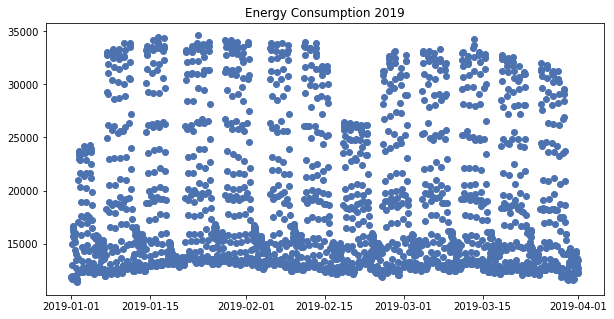

In [49]:
# ts2019 = ts['2019-01-01':'2019-04-01']
ts2017 = ts['2017-01-01':'2018-01-01']
ts2018 = ts['2018-01-01':'2019-01-01']
ts2019 = ts['2019-01-01':'2020-01-01']
# fig,ax =  plt.subplots(1,figsize=(10,5))
fig,ax =  plt.subplots(3,figsize=(10,5))

# ax[0].plot(ts2017,'o')
# ax[0].set_title('Energy Consumption 2017')
# ax[1].plot(ts2018,'o')
# ax[1].set_title('Energy Consumption 2018')
# ax[2].plot(ts2019,'o')
# ax[2].set_title('Energy Consumption 2019')
ax.plot(ts2019,'o')
ax.set_title('Energy Consumption 2019')

plt.show()

We could already identify some general patterns from the data above. For example, we notice that the demand peaks in winter-spring then bottoms out during summer. We should zoom in on different parts of the series.

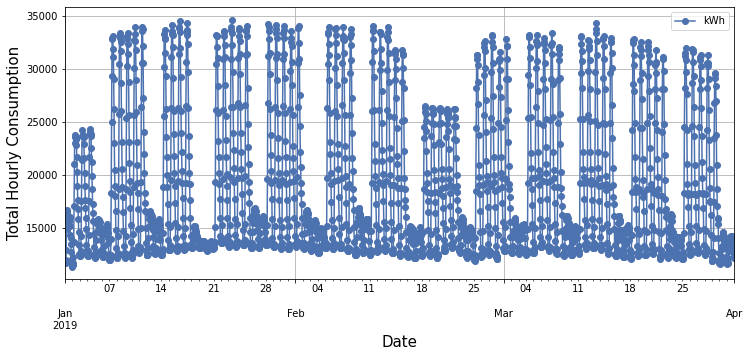

In [62]:
# start = '2019-01-01'
# end = '2019-04-01'
start = '2017-01-01'
end = '2020-01-01'

ts.loc[start:end].plot(figsize=(12,5), style='o-')
#     y_tick = np.arange(10,100,10)
#     plt.yticks(y_tick)
#     plt.title('',fontsize=15,loc='center',verticalalignment='bottom') #fontweight='bold'
#     plt.legend(bbox_to_anchor=(1,0.23),fontsize=10, loc='right')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Hourly Consumption',fontsize=15)
plt.grid()
plt.savefig('data characteristics.pdf',bbox_inches = 'tight')
plt.show()  

It looks like that during the holidays (winter - new year), there is low electricity demand. In addition, during the weekend, the demand is lower than in the weekdays. Next, we investigate the summer months.

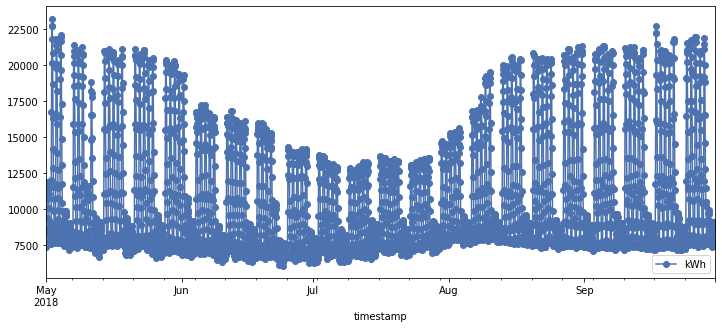

In [18]:
# plot(ts, '2018-05-01', '2018-09-30')

Compared to the plot above, it is clear that the demand in the summer is lower than the other seasons. There is a decreasing trend in demand in the first half of the year, and there is an increasing trend in the second half of the year. This situation should be the same for 2017: 

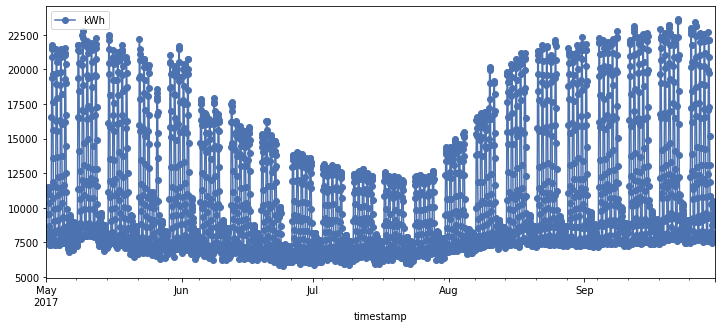

In [19]:
# plot(ts, '2017-05-01', '2017-09-30')

Indeed it is. Next, we zoom in on a random week.

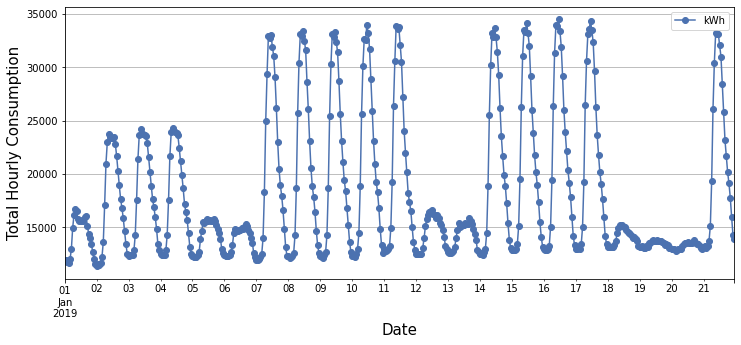

In [69]:
# plot(ts, '2017-06-25', '2017-07-08')
# start = '2019-01-01'
# end = '2019-01-21'
start = '2017-06-25'
end = '2017-07-08'

ts.loc[start:end].plot(figsize=(12,5), style='o-')
#     y_tick = np.arange(10,100,10)
#     plt.yticks(y_tick)
#     plt.title('',fontsize=15,loc='center',verticalalignment='bottom') #fontweight='bold'
#     plt.legend(bbox_to_anchor=(1,0.23),fontsize=10, loc='right')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Total Hourly Consumption',fontsize=15)
plt.grid()
plt.savefig('data_characteristics_daily.pdf',bbox_inches = 'tight')
plt.show()  

The plot above further emphasizes the weekly trend as well as reveals the daily trends: the demand tend to peak locally at around noon (Finnish time). The trends and seasonalities above (except for the daily seasonality) are also explained in the Exploratory Data Analysis for daily data section.

Since this is a time series, we should look at its autocorrelation function plot to identify any patterns that could potentially help us build common models such as ARIMA.

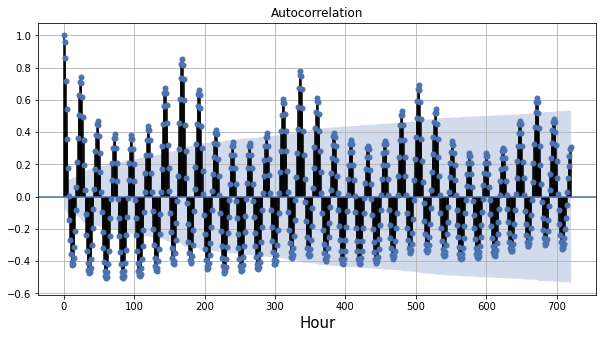

In [70]:
with rc_context():
    rc("figure", figsize=(10,5))
    plot_acf(ts['kWh'], lags=720) # 720 hours, or 30 days
    plt.xlabel('Hour', fontsize=15)
#     plt.ylabel('Total Hourly Consumption',fontsize=15)
    plt.grid()
    plt.savefig('data_autocorrelation.pdf',bbox_inches = 'tight')
    plt.show()

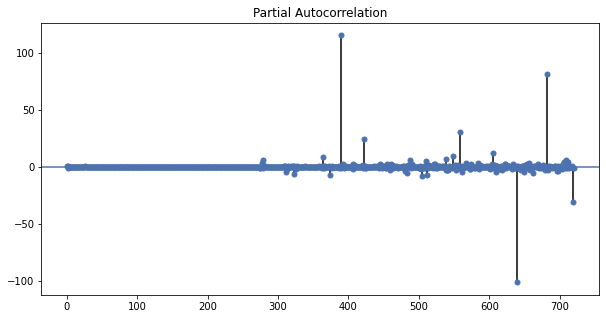

In [52]:
with rc_context(): # takes quite some time to run
    rc("figure", figsize=(10,5))
    plot_pacf(ts['kWh'], lags=720)
    plt.show()

As is identified above and further confirmed with these two plots, this time series has multiple seasonality and complex seasonality patterns. For this kind of time series, ARIMA (a common time series model) will not work very well.

Here, we also try to decompose the time series with the `STL` method. The period is $24\times 7$ hours because from most of the plots above (and from the previous EDA section on daily data), there is a weekly cycle, and there are $24\times 7$ hours in a week. Of course, there are other seasonalities in this data, but the period mentioned above should demonstrate well this decomposition.

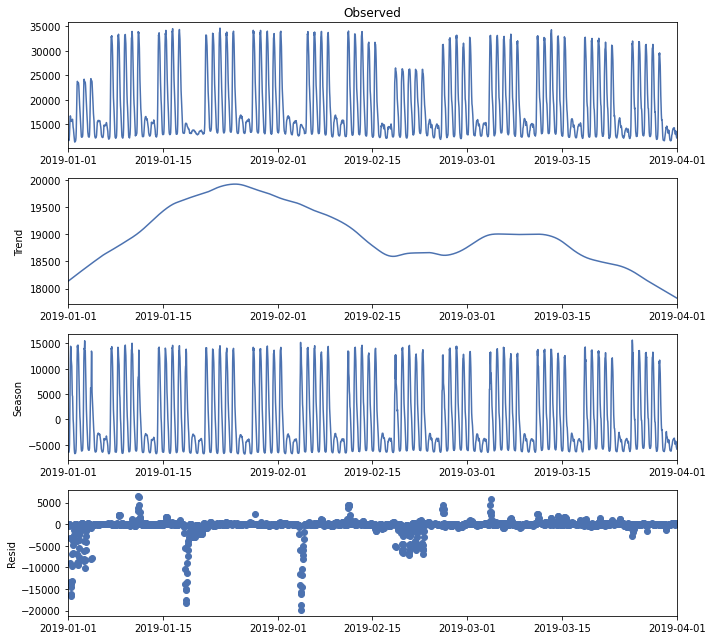

In [71]:
plt.rcParams.update({'figure.figsize':(10,9)})
stl = STL(ts2019,period=24*7,robust=True)
res = stl.fit()
fig = res.plot()

Now, we are pretty confident that the hourly electricity demand time series consists of three main components: A (yearly) trend that reaches bottom in July, a complex seasonality component (with multiple other seasonality sub-components), and holiday effects.

## Models: Prophet <a class="anchor" id="4."></a>

### Loaded modules and preparing data <a class="anchor" id="4.1."></a>

In [6]:
import pandas as pd
import numpy as np

# Facebook Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_seasonality
import prophet.plot

# Plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [7]:
import logging
logging.getLogger().setLevel(logging.ERROR)
logging.getLogger("pystan").setLevel(logging.ERROR)
logging.getLogger("prophet").setLevel(logging.ERROR)

First, we load in the hourly data created in the wrangling step.

In [8]:
df = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
df

,kWh
timestamp,
2019-01-01 00:00:00,11865.25
2019-01-01 01:00:00,11898.05
2019-01-01 02:00:00,11741.78
2019-01-01 03:00:00,11662.78
2019-01-01 04:00:00,11986.15
...,...
2019-03-31 20:00:00,13619.95
2019-03-31 21:00:00,13476.02
2019-03-31 22:00:00,12665.50


Next, we rename the columns for use in the models below. The models below expect the data to have a `ds` column (representing the timestamps) and a `y` column (representing the values of the time series).

In [9]:
df.index.names = ['ds']
df.rename(columns={'kWh':'y'}, inplace=True)
df.head()

,y
ds,
2019-01-01 00:00:00,11865.25
2019-01-01 01:00:00,11898.05
2019-01-01 02:00:00,11741.78
2019-01-01 03:00:00,11662.78
2019-01-01 04:00:00,11986.15


We divide the data into three sets: train, validation, and test sets. The test set starts from the timestamp 2019-12-01. In the remaing portion of the data, the first 80% of it is used for training, and the remaining 20% is used for validation. However, we may choose not to generate the validation set if it's not necessary.

In [10]:
def train_val_test_split(df, validation=True):
#     train_end = '2019-04-01 00:00:00'
    train_end = '2019-12-01 00:00:00'

    train_val = df.loc[:train_end, :]
    test_df = df.loc[train_end:, :]

    # Let the ds indexing column be its own column as is required by the models below.
    for df in [train_val, test_df]:
        df.reset_index(inplace=True)
        
    if not validation:
        return train_val, test_df

    n = len(train_val)
    cutoff = int(n*0.8)

    train_df = train_val[:cutoff]
    val_df = train_val[cutoff:]
    return train_df, val_df, test_df

In [11]:
train_df, val_df, test_df = train_val_test_split(df)

### Prophet: Description <a class="anchor" id="4.2."></a>

Prophet is a open-source project from Facebook that aims to model time series data and make reliable forecasts. Essentially, a Prophet model is an additive model with several components: a seasonal component with multiple levels (e.g., yearly, weekly, daily, and user-defined seasonalities), a trend component which can be highly non-linear, and holiday effects. Prophet fits models with Stan, a probabilistic programming framework. Prophet estimates the parameters with maximum a posteriori estimates by default.


The model can typically be expressed with the following formula:

$$
\begin{aligned}
y_t=g(t)+s(t)+h(t)
\end{aligned}
$$

where:

* $y_t$ is the time series

* $g(t)$ is a (possibly smooth and nonlinear) function of the trend

* $s(t)$ represents the seasonal, periodic changes (e.g., yearly and weekly seasonalities)

* $h(t)$ models the effects of holidays, whose schedule may be irregular.

For more information, please see the article ([Taylor et al., 2018](https://peerj.com/preprints/3190/)).

In [12]:
# Helper functions for Prophet model fitting and plotting.

def to_exp(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.exp)
    return res


def to_log(df, colnames):
    res = df.copy()
    for colname in colnames:
        res[colname] = res[colname].apply(np.log)
    return res


def plot(forecast, train, x1,x2):
    """
    Plots two time series 'forecast' and 'train' in one plot mainly to compare them.
    Also plots the first time series against the second time series to determine 
    how similar they are. x1 is the starting time point and x2 is the ending time point.
    """
    yhat = forecast.set_index('ds').loc[x1:x2, 'yhat']
    y = train.set_index('ds').loc[x1:x2, 'y']
    plt.figure(figsize=(15,7))
    plt.plot(yhat, 'o-', label='Estimated')
    plt.plot(y, 'o', label='True')
    lower = forecast.set_index('ds').loc[x1:x2, 'yhat_lower']
    upper = forecast.set_index('ds').loc[x1:x2, 'yhat_upper']
    plt.fill_between(yhat.index, lower, upper, alpha=0.2)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10,5))
    plt.scatter(x=y, y=yhat)
    min_x = int(np.floor(np.min([yhat.min(), y.min()]))) 
    max_x = int(np.ceil(np.max([yhat.max(), y.max()])))
    r = range(min_x,max_x)
    plt.plot(r, r, 'r', label='y=x')
    plt.title('True (x-axis) against estimated (y-axis)')
    plt.legend()
    plt.show()
    

def acf_res(forecast, train):
    """
    Plots a autocorrelation plot of the residuals (y-true minus y-predicted) for training data.
    """
    date_range = train['ds']
    res = train.set_index('ds')['y'] - forecast.set_index('ds').loc[date_range, 'yhat']
    plot_acf(res)

    
def is_spring(ds):
    return ds.month in [3,4,5]

    
def is_summer(ds):
    """
    Determines whethere a timestamp ds is in the summer or not.
    """
    return ds.month in [6,7,8]


def is_winter(ds):
    """
    Determines whether a timestamp ds is in the winter.
    """
    return ds.month in [12,1,2]


def is_autumn(ds):
    return ds.month in [9,10,11]
    
    
def is_weekend(ds):
    """
    Determines whether a timestamp ds is in the weekend.
    """
    return ds.day_name() in ['Saturday', 'Sunday']


def is_weekday(ds):
    """
    Determines whether a timestamp ds is a weekday.
    """
    return not is_weekend(ds)


def is_winter_weekday(ds):
    """
    Determines whether a timestamp ds is a winter weekday.
    """
    return is_winter(ds) and is_weekday(ds)


def is_winter_weekend(ds):
    """
    Determines whether a timestamp ds is a winter weekend.
    """
    return is_winter(ds) and is_weekend(ds)


def is_summer_weekday(ds):
    """
    Determines whether a timestamp ds is a summer weekday.
    """
    return is_summer(ds) and is_weekday(ds)


def is_summer_weekend(ds):
    """
    Determines whether a timestamp ds is a summer weekend.
    """
    return is_summer(ds) and is_weekend(ds)


def is_first_half(ds):
    """
    Determines whether a timestamp is in the first half of a year (spring-summer)
    """
    return (ds.month >= 2 and ds.month <= 7)


def is_second_half(ds):
    """
    Determines whether a timestamp is in the second half of a year (autumn-summer)
    """
    return not is_first_half(ds)


def is_spring_weekday(ds):
    return is_spring(ds) and is_weekday(ds)


def is_spring_weekend(ds):
    return is_spring(ds) and is_weekend(ds)


def is_autumn_weekday(ds):
    return is_autumn(ds) and is_weekday(ds)


def is_autumn_weekend(ds):
    return is_autumn(ds) and is_weekend(ds)


def add_custom_seasonality(df):
    """
    Augments the dataframe df with several columns determining
    whether the corresponding datapoints belong to different seasoonalities. 
    """
    df = df.assign(
                       spring_weekday = df['ds'].apply(is_spring_weekday),
                       spring_weekend = df['ds'].apply(is_spring_weekend),
                       summer_weekday = df['ds'].apply(is_summer_weekday),
                       summer_weekend = df['ds'].apply(is_summer_weekend),
                       autumn_weekday = df['ds'].apply(is_autumn_weekday),
                       autumn_weekend = df['ds'].apply(is_autumn_weekend),
                       winter_weekday = df['ds'].apply(is_winter_weekday),
                       winter_weekend = df['ds'].apply(is_winter_weekend),
                       summer = df['ds'].apply(is_summer),
                       winter = df['ds'].apply(is_winter),
                       weekend = df['ds'].apply(is_weekend),
                       weekday = df['ds'].apply(is_weekday)
                  )
    return df


def mape(y_true, y_pred):
    """
    calculates the mean absolute percentage error, for use below
    """
    return mean_absolute_percentage_error(y_true, y_pred)

### Default Prophet model <a class="anchor" id="4.3."></a>

First, we try the default Prophet model, that is, we do not specify any further options and use the default arguments for its `fit` method. In a default Prophet model for hourly time series, there is a yearly seasonality, weekly seasonality, and daily seasonality, The growth is linear and the components are additive.

In [13]:
model_default = Prophet(interval_width=0.95) # for each estimate, return a 95% interval
model_default.fit(train_df)
None

After fitting the `model_default` on the train dataset, we use it to make forecasts on the validation dataset.

In [14]:
future = model_default.make_future_dataframe(periods=len(val_df), freq='H')
forecast = model_default.predict(future)

The plot below shows the fitted values (blue curve) against the true data (black dots). The blue bands are 95% uncertainty intervals.

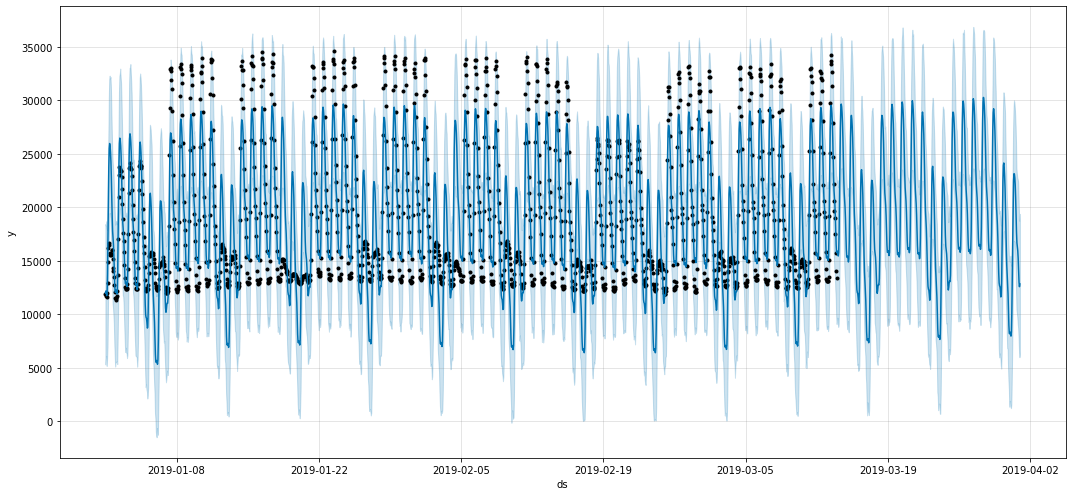

In [15]:
fig1 = model_default.plot(forecast, figsize=(15,7))

As we can see, the fit is not satisfactory as the model underestimates and overestimates the data at regular intervals (the blue line is consistently lower and higher than the black "curve" (dots), even if the 95% intervals cover the black dots.

We should zoom in on a time period to investigate the fits.

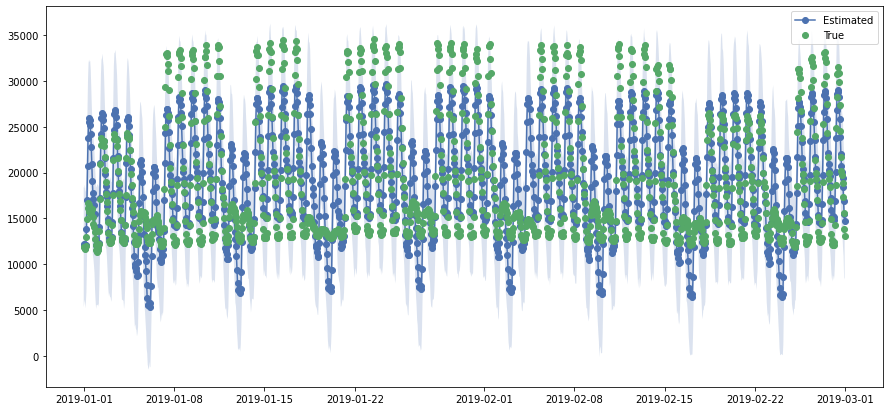

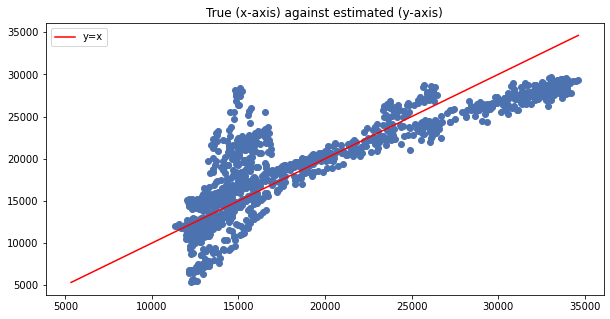

In [16]:
# plot(forecast, train_df, '2019-01', '2019-02')
plot(forecast, train_df, '2019-07', '2019-09')

Additionally, we investigate the autocorrelation plot of the residuals, i.e., true value minus predicted value.

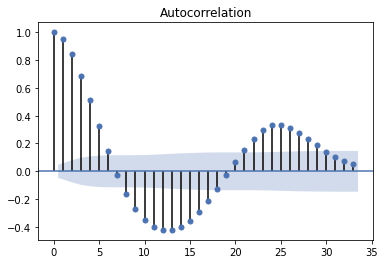

In [17]:
acf_res(forecast, train_df)

In a satisfactory (ARIMA) model, the autocorrelations should be very low (they should lie within the blue 95% confidence band). However, in the plot above, not only are the autocorrelations high, they also lie outside the band. Since we did not include any autoregressive terms, this bad fit is to be expected.

From all plots above, we can conclude that the model regularly underestimates as well as overestimates the data, and that the model is not satisfactory.

Next, we plot some components of the models: the trend and the seasonalities.

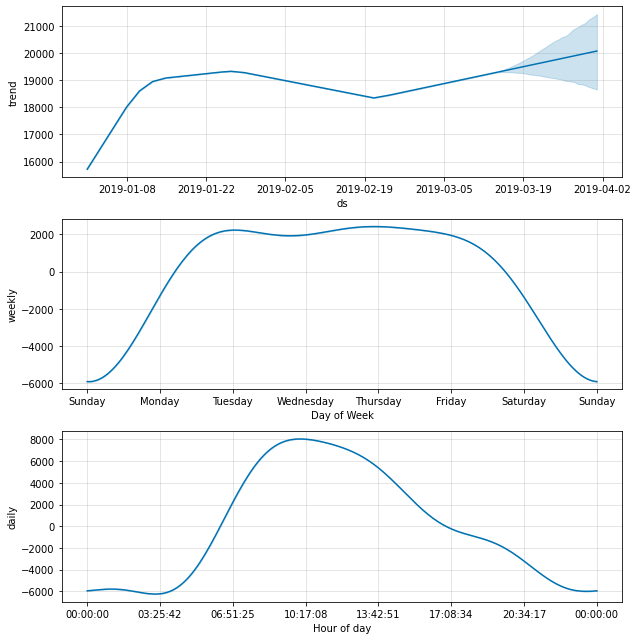

In [18]:
fig2 = model_default.plot_components(forecast)

Remarks: the default model correctly identifies that during a day, the electricity demand typically reaches its daily peak around noon (the time zone of the data is in UTC, but the origin of the data is in UTC+2 or UTC+3 time zone). It also correctly identifies that in a year, the demand typically reaches its lowest in the summer. In contrast, the demand is typically very high in the winter. In addition, in a week, the model correctly identifies that the demand is lower in weekends and higher in weekdays.

### Better Prophet model <a class="anchor" id="4.4."></a>

#### Fitting the model <a class="anchor" id="4.4.1."></a>

After a careful look at the data, we observe that in the summer, the within-day variation in electricity demand seems to be smaller than that in the winter. This suggests that this variation has a multiplicative effect. In addition, we notice that the demand is always lower in the weekend than during the weekdays. In addition, within each year, we see that there is a decreasing trend in the first half of the year and an increasing trend in the second half of the year.

In light of the observations above, we add our custom seasonalities. First of all, we add seasonalities for weekends and weekdays for each season (winter, spring, summer, autumn). However, we transform the data by logarithmizing the values because we wish the seasonalities to have a multiplicative effect on each other as log of a product is a sum:

$$
\begin{aligned}
y_t&=g(t)\times s(t)\times h(t)\\
\Rightarrow \log{y_t}&=\log{g(t)}+\log{s(t)}+\log{h(t)}
\end{aligned}
$$

In [19]:
train_df, val_df, test_df = train_val_test_split(to_log(df, ['y']))
train_df = add_custom_seasonality(train_df)
val_df = add_custom_seasonality(val_df)
test_df = add_custom_seasonality(test_df)
future = add_custom_seasonality(future)

In [38]:
a = pd.date_range(start='2017-01-01', end='2017-01-08', freq='1D').to_series()
b = pd.date_range(start='2017-12-20', end='2018-01-08', freq='1D').to_series()
c = pd.date_range(start='2018-12-20', end='2019-01-08', freq='1D').to_series()
d = pd.date_range(start='2019-12-20', end='2020-01-01', freq='1D').to_series()

# In Finland, usually Christmas and New year holidays last acoording to the date ranges above
christmas_newyear = pd.DataFrame({
    'holiday': 'christmas_newyear',
    'ds': pd.concat([a, b, c, d], axis=0).values
})

In [39]:
def better_prophet():
    model_improved = Prophet(
        changepoint_prior_scale=0.5,
        daily_seasonality=False,
        holidays = christmas_newyear,
        interval_width=0.95)

    # The higher the fourier_order, the more wiggly the seasonality component becomes
    model_improved.add_seasonality(name='spring_weekday', period=1, fourier_order=12, condition_name='spring_weekday')
    model_improved.add_seasonality(name='spring_weekend', period=1, fourier_order=12, condition_name='spring_weekend')
    model_improved.add_seasonality(name='summer_weekday', period=1, fourier_order=12, condition_name='summer_weekday')
    model_improved.add_seasonality(name='summer_weekend', period=1, fourier_order=12, condition_name='summer_weekend')
    model_improved.add_seasonality(name='autumn_weekday', period=1, fourier_order=12, condition_name='autumn_weekday')
    model_improved.add_seasonality(name='autumn_weekend', period=1, fourier_order=12, condition_name='autumn_weekend')
    model_improved.add_seasonality(name='winter_weekday', period=1, fourier_order=12, condition_name='winter_weekday')
    model_improved.add_seasonality(name='winter_weekend', period=1, fourier_order=12, condition_name='winter_weekend')
    model_improved.add_country_holidays(country_name='Finland')
    return model_improved

In [40]:
model_improved = better_prophet()
model_improved.fit(train_df)
None

Initial log joint probability = -27.4921
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       86957.1   0.000503586       16715.3           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         87118   0.000447545       7700.55           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       87185.4   0.000511386       22496.1       0.422           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       87258.7    0.00216175       10073.4      0.5063           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       87286.2   0.000819403       6115.44           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

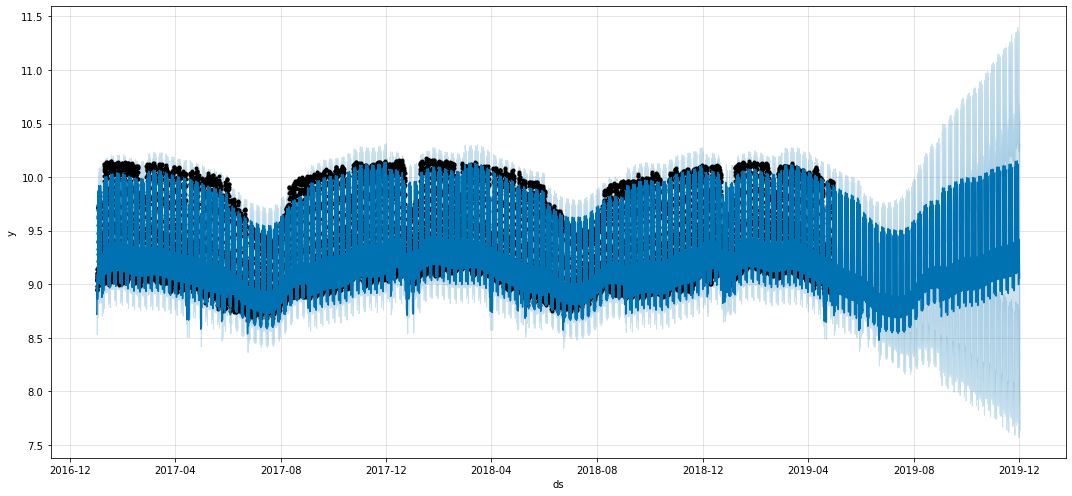

In [41]:
forecast_improved = model_improved.predict(future)

fig1 = model_improved.plot(forecast_improved, figsize=(15,7))

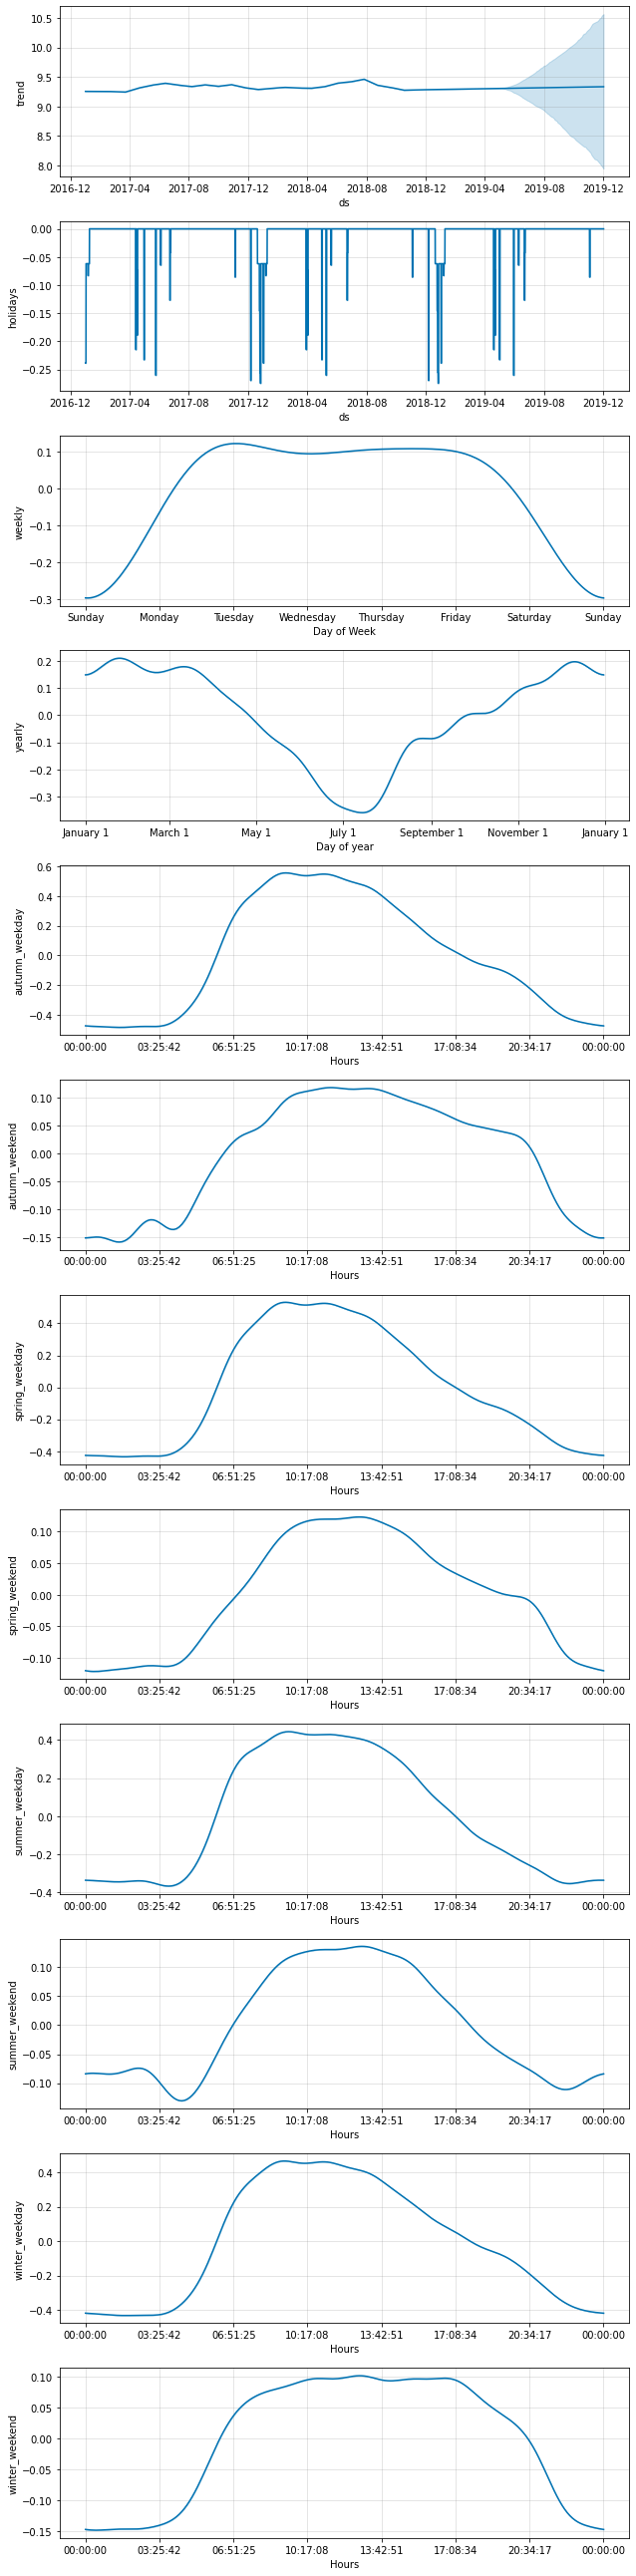

In [42]:
fig2 = model_improved.plot_components(forecast_improved)

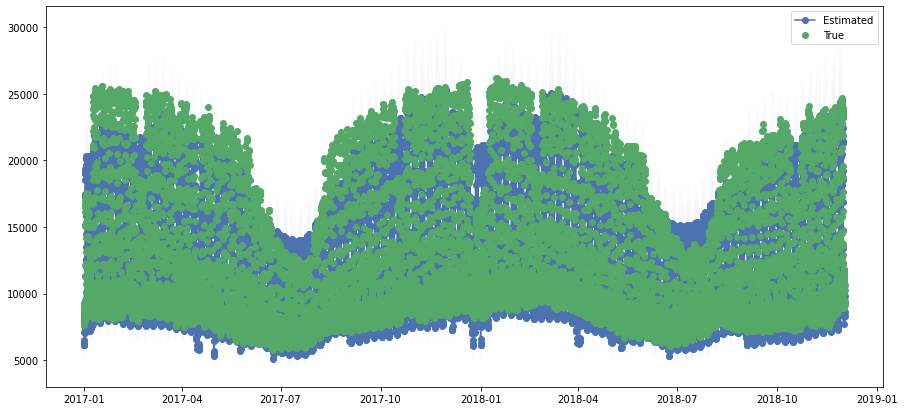

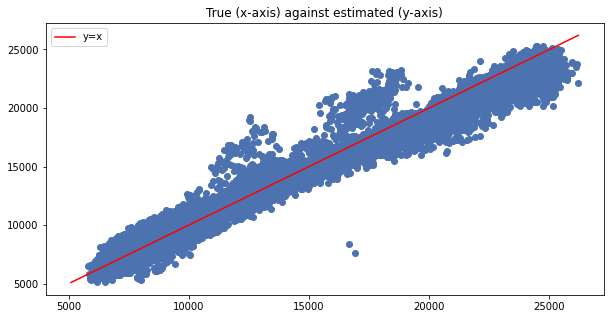

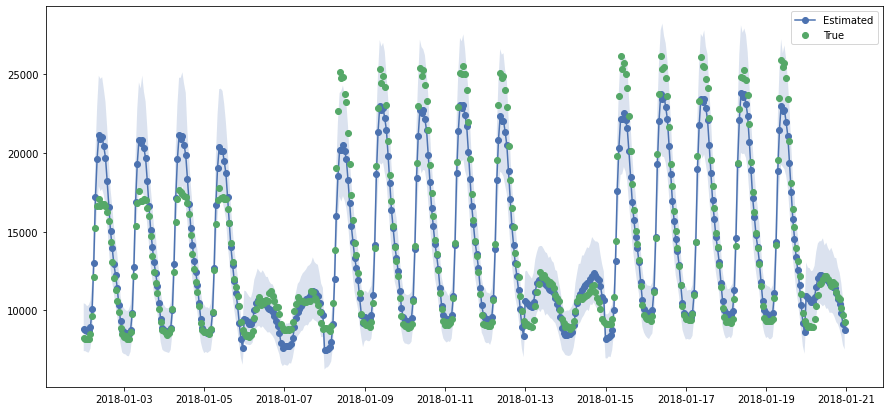

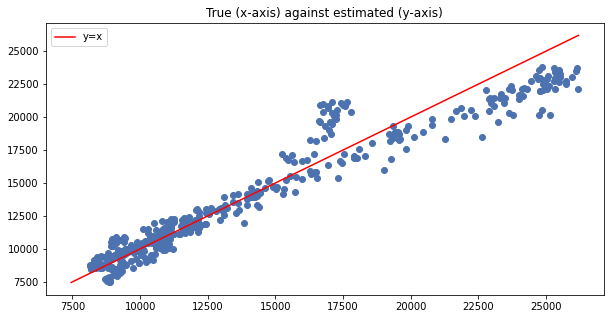

In [43]:
plot(to_exp(forecast_improved, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2017-01-01', '2018-12-01')
plot(to_exp(forecast_improved, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(train_df, ['y']), '2018-01-02', '2018-01-20')

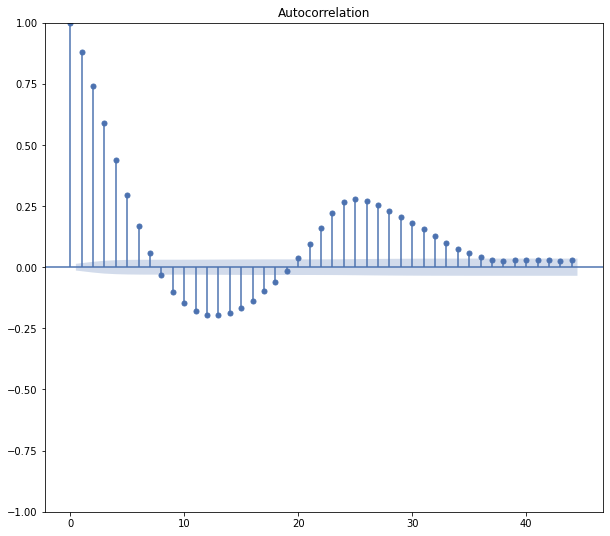

In [44]:
acf_res(forecast_improved, train_df)

Although the model consistently overpredicts in the summer, the forecasts are quite satisfactory in other seasons. Judging from the last plot above, the residual autocorrelations are much lower than those of the previous model.

#### Cross-validation <a class="anchor" id="4.4.2."></a>

Cross-validation on time series data is different from that on common non time-series data because there is a time structure which must not be broken with random partitioning used in normal cross-validation methods. This is why Prophet has its own cross-validation methods.

The cross-validation procedure is as follows. First, the model is trained on the first 8766 hours of the data (initial). Then, it forecasts the next 720 hours of data (horizon). After that, the model is trained on the first 8766 hours plus the next 1440 hours (period by default) and make predictions on the next 720 hours after that 360 hours. This procedure continues (training data has 1440-hour increments and forecasts are made on the next 720 hours) until there is not enough data left to do this.

In [45]:
df_cv = cross_validation(model_improved, initial='8766 hours', period='1440 hours', horizon='720 hours', parallel="processes")

Initial log joint probability = -11.471
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.0729
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.8625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.9933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -20.1531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.0252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.6015
    Iter      log prob        

In [46]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days 00:00:00,0.004003,0.063267,0.049847,0.005384,0.004173,0.005380,0.986111
1,3 days 01:00:00,0.004006,0.063297,0.049836,0.005383,0.004160,0.005379,0.986111
2,3 days 02:00:00,0.004136,0.064312,0.050037,0.005405,0.004137,0.005401,0.984375
3,3 days 03:00:00,0.004651,0.068198,0.050931,0.005503,0.004137,0.005495,0.980903
4,3 days 04:00:00,0.005495,0.074128,0.052231,0.005644,0.004121,0.005631,0.977431
...,...,...,...,...,...,...,...,...
644,29 days 20:00:00,0.023983,0.154864,0.117670,0.012609,0.009267,0.012619,0.925347
645,29 days 21:00:00,0.023880,0.154532,0.117301,0.012568,0.009139,0.012577,0.925347
646,29 days 22:00:00,0.023819,0.154335,0.117123,0.012548,0.009054,0.012557,0.925347
647,29 days 23:00:00,0.023717,0.154004,0.116742,0.012505,0.009054,0.012514,0.925347


We focus on the mean absolute percentage error (MAPE). The absolute percentage error is the absolute value of the proportion of the difference between the true value and the predicted value to the true value. MAPE is a mean of those errors:

$$
\begin{aligned}
\text{MAPE}=\frac{1}{n}\sum_{t=1}^n\left|\frac{y-\hat{y}}{y}\right|
\end{aligned}
$$

This error function can be measured in percentages and is thus easy to understand. The lower this error is, the better the prediction.

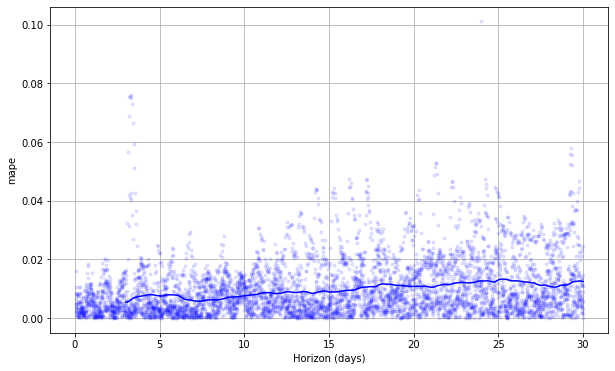

In [47]:
fig_cv = plot_cross_validation_metric(df_cv, metric='mape')

### Model selection <a class="anchor" id="4.5."></a>

We could finally evaluate the better model's performance on the test set by retraining it on the aggregation of the train set and the validation set.

In [48]:
train, test = train_val_test_split(to_log(add_custom_seasonality(df.reset_index()), ['y']).set_index('ds'), validation=False)
model_final = better_prophet()
model_final.fit(train)
None

Initial log joint probability = -27.3283
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        109218    0.00197411         57025           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        109404     0.0006731       13901.9           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        109480   0.000404305       26704.6           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        109518    2.5434e-05       4222.74      0.8493      0.8493      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        109597    0.00184531       9185.27           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [49]:
future = model_final.make_future_dataframe(periods=len(test), freq='H')
future = add_custom_seasonality(future)
forecast = model_final.predict(future)

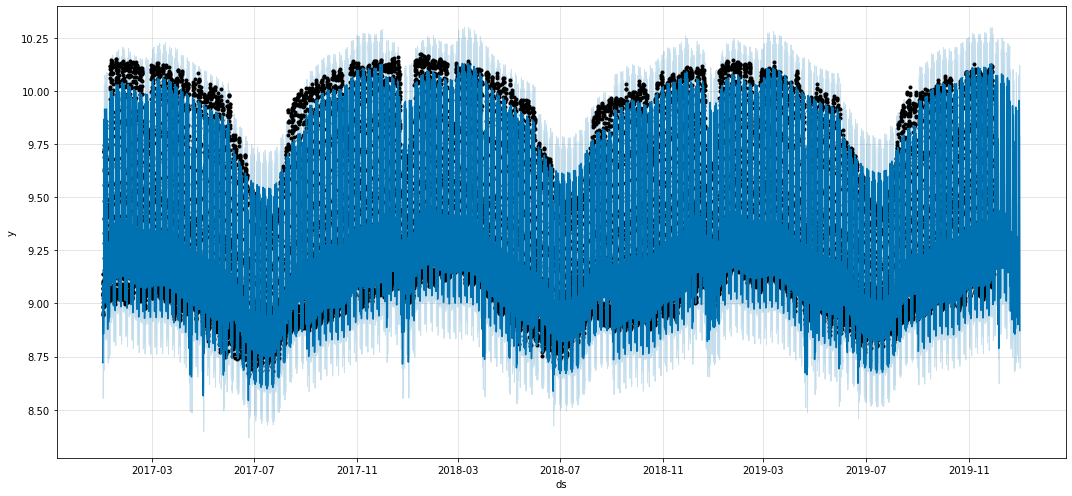

In [50]:
fig1 = model_final.plot(forecast, figsize=(15,7))

Note that for Prophet models, the wider the blue bands (relative to the predictions), the more likely the model is overfit. Here, we see that this is not the case. Now, we evaluate the model on the test set:

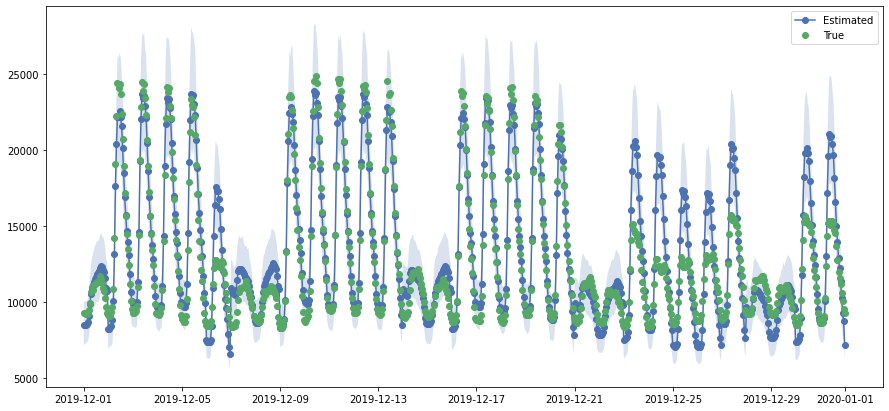

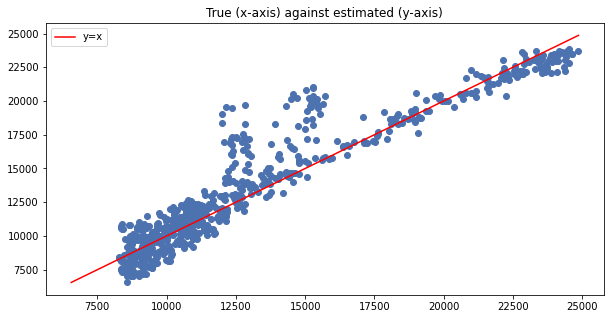

In [51]:
plot(to_exp(forecast, ['yhat', 'yhat_lower', 'yhat_upper']), to_exp(test, ['y']), '2019-12-01 00:00:00', '2020-01-01 00:00:00')

Visually, it seems like the model is a good fit although it overpredicts on Christmas holidays. Now we need to check the error of the model on the test set.

In [52]:
from sklearn.metrics import mean_squared_error

ytrue = to_exp(test, ['y'])['y']
ypred = to_exp(forecast, ['yhat']).set_index('ds').loc['2019-12-01 00:00:00':'2020-01-01 00:00:00'].reset_index()['yhat']
rmse = np.sqrt(mean_squared_error(ytrue, ypred))

print(f"The RMSE of the better model is: {rmse:.2f}")
print(f"The MAPE of the better model is: {mape(ytrue, ypred):.2f}")

The RMSE of the better model is: 1572.73
The MAPE of the better model is: 0.09


We could also repeat the same procedure for the default model above.

In [53]:
train, test = train_val_test_split(df, validation=False)
m = Prophet(interval_width=0.95)
m.fit(train)
future = m.make_future_dataframe(periods=len(test), freq='H')
forecast = m.predict(future)
None

Initial log joint probability = -670.657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       48961.9   0.000882737       253.515      0.6919      0.6919      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       48965.1   0.000924023        219.26           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       48966.1   0.000153786       107.778           1           1      385   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       48966.6   2.74294e-05        142.61   1.574e-07       0.001      541  LS failed, Hessian reset 
     399       48966.8   0.000678339       128.448       9.676      0.9676      565   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     442       48966.9   4.87531e-05    

In [54]:
ypred2 = forecast.set_index('ds').loc['2019-12-01 00:00:00':'2020-01-01 00:00:00'].reset_index()['yhat']
rmse2 = np.sqrt(mean_squared_error(test['y'], ypred2))
print(f"The RMSE of the default model is: {rmse2:.2f}")
print(f"The MAPE of the default model is: {mape(test['y'], ypred2):.2f}")

The RMSE of the default model is: 2676.30
The MAPE of the default model is: 0.18


The MAPE of the better model is half that of the default model. The RMSE is also much lower. We successfully improved on the default model.

The purpose of the validation set was to help tune the hyperparameters of the Prophet models. This is not of great importance to this project, but we could try doing it in the future.

LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import datetime # manipulating date formats
import holidays
import IPython
import IPython.display


from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from torch.autograd import Variable

# settings
plt.style.use('seaborn-deep')

In [ ]:
# ts = pd.read_csv("hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts = pd.read_csv("3y_hourly_total.csv", parse_dates=['timestamp'], index_col=['timestamp'])
ts.head()
ts.plot(figsize=(10,5),style="o")

In [ ]:
begin = '2017-01-01'
end = '2019-12-31' # errors within the holidays package
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

In [ ]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [ ]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

In [ ]:
plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [ ]:
ts.head(10)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(ts[["kWh"]])
ts_normalized = pd.DataFrame(scaler.fit_transform(ts),
                             columns = ts.columns.values,
                            index = ts.index)

In [ ]:
ts_normalized.head()

In [ ]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

test_df = ts_normalized[train_end:]
train_val = ts_normalized[:train_end]

n = len(train_val)

train_df = train_val[:int(n*0.8)]
val_df = train_val[int(n*0.8):]

column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train_df

In [ ]:
import random

def split_sequence(df, fea_width=28, label_width=1, shift=1, label_col_indices=[0], randomize = True):
    
    """ Split sequence with sliding window into
        sequences of context features and label.
        Args:
            df (DataFrame): the target time series
            fea_width (int): Length of features vector.
            label_width (int): Length of labels vector.
            shift (int): Distance between the features vector and the labels one. 
            label_col_indices (list): list of the columns for the labels.
        Return:
            X (np.array): sequence of features
            y (np.array): sequence of targets
    """
    arr = df.to_numpy()

    # Work out the label column indices.

    window_size = fea_width + shift + label_width - 1
    fea_slice = slice(0, fea_width)
    fea_indices = np.arange(window_size)[fea_slice]

    label_slice = slice(window_size - label_width, None)
    label_indices = np.arange(window_size)[label_slice]
    
    
    print("\n window_size: {} \n fea_indices: {} \n label_indices: {}"
          .format(window_size,fea_indices,label_indices))
    
    
    def split_window(window):
        features = window[fea_slice]
        labels = window[label_slice]
#         print(label_col)
#         print([label_col_indices[name] for name in label_col])
        if label_col_indices is not None:
            labels = np.stack(
                [labels[:, label_col_indices[idx]] 
                 for idx in label_col_indices],
                axis=-1)
        
        labels = labels.flatten()
        
        return features, labels
            
    n = len(arr)
    X,y = list(),list()
    for i in range(0, n, shift):
        
        window = arr[i:i+window_size]
        if (len(window) != window_size): break
        
        # Find the end of this pattern:
        features,labels = split_window(window)
        X.append(features)
        y.append(labels)
        
#     print(label_col_indices)
#     if randomize == True:
#         random.shuffle(X)
#         random.shuffle(y)
    
    return X,y

In [ ]:
fea_width, label_width, shift, label_col_indices = 28, 1, 1, [0]

X_ts,y_ts = split_sequence(ts_normalized,randomize=False)

X_train,y_train = split_sequence(train_df)
X_val,y_val = split_sequence(val_df)
X_test,y_test = split_sequence(test_df)

X_train[0].shape,y_train[0].shape

In [ ]:
def to_tensor(ls):
    return Variable(torch.cuda.FloatTensor(np.array(ls)))

X_ts,y_ts = to_tensor(X_ts),to_tensor(y_ts)

X_train,y_train = to_tensor(X_train),to_tensor(y_train)
X_val,y_val = to_tensor(X_val),to_tensor(y_val)
X_test = to_tensor(X_test)

X_train

In [ ]:
from fastprogress import master_bar, progress_bar
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
from torch.autograd import Variable

import torch
import torch
import torch.nn as nn

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
        
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).cuda())
        
       
        _, (hn, cn) = self.LSTM(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
num_epochs = 300
learning_rate = 1e-3
input_size = 4
hidden_size = 512
num_layers = 2

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers)
model.cuda()


model.apply(init_weights)

criterion = torch.nn.MSELoss().cuda()    # Will be transformed to root mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
for epoch in progress_bar(range(1,num_epochs+1)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    
    loss = torch.sqrt(criterion(y_pred, y_train))
    loss.backward()
    
    optimizer.step()
    
    model.eval()
    valid = model(X_val)
    val_loss = torch.sqrt(criterion(valid, y_val))
    scheduler.step(val_loss)
    
    if epoch%20 == 1:
        print("Epoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

print("Final: \nEpoch: %d, loss: %1.5f validation loss:  %1.5f " 
              %(epoch, loss.item(),val_loss.item()))

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

model.eval()

## Inverse Normalize 
y_test_pred = scaler_kwh.inverse_transform(model(X_test).cpu().detach().numpy())
y_test_obs = scaler_kwh.inverse_transform(y_test)

print('The root mean squared error of the model is ' +
      str(round(np.sqrt(mean_squared_error(y_test_obs,y_test_pred)),2)) +
      '\nThe root mean squared error of the model is ' + 
     str(round(mean_absolute_percentage_error(y_test_obs,y_test_pred),2)))

In [ ]:
y_pred = scaler_kwh.inverse_transform(model(X_ts).cpu().detach().numpy())
y_obs = scaler_kwh.inverse_transform(y_ts.cpu().numpy())

pred_df = pd.DataFrame(y_pred,index = ts.index[-len(y_pred):],columns = ["kWh"])
obs_df = pd.DataFrame(y_obs,index = ts.index[-len(y_pred):],columns = ["kWh"])

fig, ax = plt.subplots()
plot_df = pd.concat([obs_df,pred_df],axis=1)
plot_df.plot(ax=ax,figsize=(12,7),style = 'o', grid=True)
ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption 2017-2019")
ax.set_ylabel("kWh")

In [ ]:
fig, ax = plt.subplots()
plot_df.loc[train_end:].plot(ax = ax, figsize=(12,7), grid=True)

ax.legend(["Observed", "Forecasts"])
ax.set_title("Energy Consumption December 2019")
ax.set_ylabel("kWh")